In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import yaml

from astropy import units as u
from astropy.coordinates import Longitude, Latitude, EarthLocation
from mpl_toolkits.basemap import Basemap
from numpy import recarray

from ipywidgets import widgets
from IPython.display import display

## Read MeerKAT config file with antenna positions

In [2]:
class MKAT(object):
    def __init__(self, mkat_config):
        self.ref_position = None
        arr_desc = {'names': ('name', 'east', 'north', 'up', 'location'),
                    'formats': ('S5', float, float, float, EarthLocation)}
        self.antennas = recarray((0,), dtype=arr_desc)
        self.build_array(mkat_config)
        
    def build_array(self, filename):
        """Read array default .yaml file."""
        with open(filename, "r") as stream:
            data = yaml.safe_load(stream)
        self.get_reference(data['reference'])
        self.get_antennas(data['antennas'])
 
    def get_reference(self, ref_position):
        """General Earth position for the Telescope"""
        ref_LAT = Latitude(ref_position['latitude'],
                           u.degree,
                           copy=False)
        ref_LON = Longitude(ref_position['longitude'],
                            u.degree,
                            wrap_angle=180. * u.degree,
                            copy=False)
        ref_ALT = u.Quantity(ref_position['altitude'],
                             u.m,
                             copy=False)
        self.ref_position = EarthLocation(lat=ref_LAT,
                                          lon=ref_LON,
                                          height=ref_ALT)
 
    def get_antennas(self, antennas):
        """ENU coordinates per antenna"""
        if self.ref_position is not None:
            [x, y, z] = self.ref_position.to_geocentric()

        self.antennas.resize(len(antennas))
        for cnt, antenna in enumerate(antennas):
            ant_ = [item.strip() for item in antenna.split(",")]
            for item_ in ant_:
                for prefix_ in ('name', 'east', 'north', 'up'):
                    val_ =  None
                    if item_.startswith(prefix_):
                        val_ =  item_.split('=')[-1].strip()
                    if val_ is not None:
                        self.antennas[cnt][prefix_] = val_
            if self.ref_position is not None:
                ant_North = x.value + self.antennas[cnt]['north']
                ant_East = y.value + self.antennas[cnt]['east']
                ant_Up = z.value + self.antennas[cnt]['up']
                self.antennas[cnt]['location'] = EarthLocation(x=ant_North * u.m,
                                                               y=ant_East * u.m,
                                                               z=ant_Up * u.m)

In [3]:
mkat = MKAT('mkat_antennas.yml')

def decode(text_):
    if isinstance(text_, str):
        text = text_
    else:
        text = text_.decode("utf-8")
    return text

# Get array
arr_latitude = []
arr_longitude = []
arr_names = []
for antenna in mkat.antennas:
    arr_names.append(decode(antenna['name']))
    arr_latitude.append(antenna['location'].lat.value)
    arr_longitude.append(antenna['location'].lon.value)

## Select antennas for array

In [4]:
class antennas():
    def __init__(self):
        
        self.antennas = {}
        self.construct_array()
        
        # build widget grid
        for ant_name in self.antennas.keys():
            self.antennas[ant_name] = self.ant_checkbox(ant_name)
        
    def construct_array(self):
        for cntr in range(0, 64):
            ant_name = 'm{:03d}'.format(cntr)
            self.antennas[ant_name] = None        
        
    def ant_checkbox(self, ant_name):
        return widgets.Checkbox(value=True,
                                description=ant_name,
                                disabled=False,
                                indent=False) 

In [5]:
def select_antennas(ant_array):
    array_ = np.empty([4, 16], dtype=widgets.Checkbox)
    for cnt, ant in enumerate(ant_array.antennas.keys()):
        array_[cnt//16, cnt%16] = ant_array.antennas[ant]
    antennas_ = widgets.VBox([widgets.HBox(array_[0,:].tolist()),
                              widgets.HBox(array_[1,:].tolist()),
                              widgets.HBox(array_[2,:].tolist()),
                              widgets.HBox(array_[3,:].tolist())])
    display(antennas_)
ant_array = antennas()
select_antennas(ant_array)

## Run to show array layout

Select the appropriate antennas from those listed above and and run the cells below to show array layout

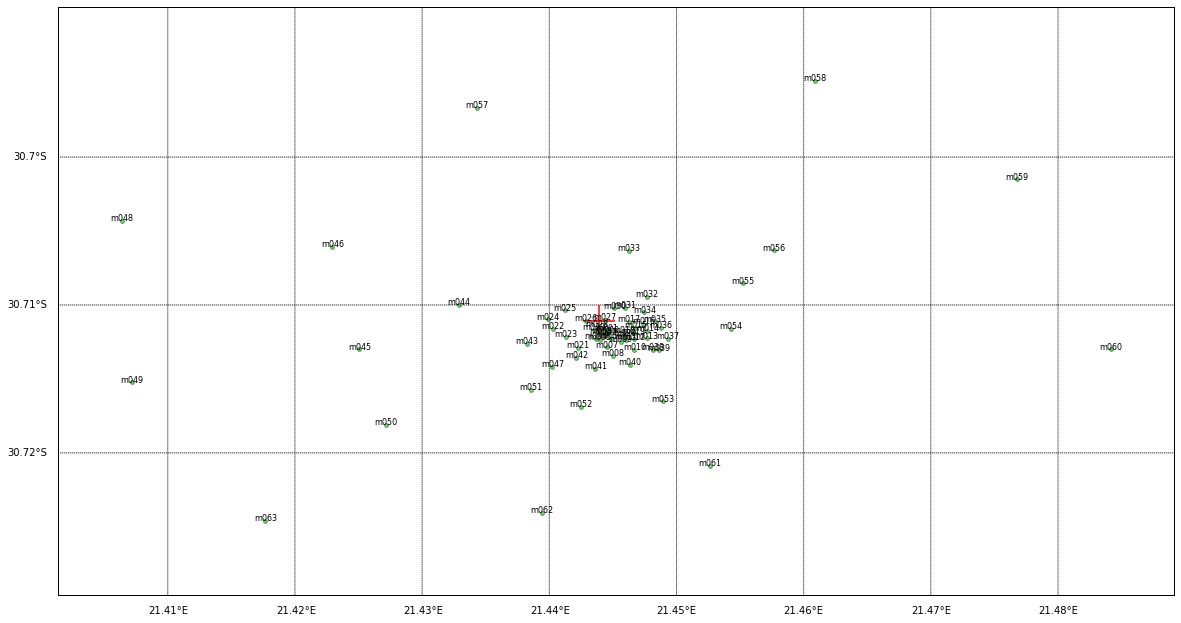

In [6]:
subarray = np.empty(np.shape(arr_names), dtype=bool)
for cnt, ant in enumerate(ant_array.antennas.keys()):
    subarray[cnt] = ant_array.antennas[ant].value

# Earth projection
m = Basemap(projection='merc',
            lat_0=mkat.ref_position.lat.value,
            lon_0=mkat.ref_position.lon.value,
            llcrnrlon=np.min(arr_longitude)-0.005,
            llcrnrlat=np.min(arr_latitude)-0.005,
            urcrnrlon=np.max(arr_longitude)+0.005,
            urcrnrlat=np.max(arr_latitude)+0.005)
# set regular grid and map projected coordinates
ref_x, ref_y = m(mkat.ref_position.lon.value, mkat.ref_position.lat.value)
arr_x, arr_y = m(arr_longitude, arr_latitude)
subarr_x, subarr_y = m(np.array(arr_longitude)[subarray], np.array(arr_latitude)[subarray])

# Array layout
plt.figure(figsize=(20, 13), facecolor='white');
# draw parallels.
parallels = np.arange(-30.73, -30.69, .01)
m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10);
# draw meridians
meridians = np.arange(21.41, 21.48, .01)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10);
m.drawmapboundary(fill_color='white');  # noqa
m.scatter(ref_x, ref_y, 1000, marker='+', color='r', label='Array reference');
m.plot(subarr_x, subarr_y, '.', markersize=8, color='g', alpha=0.5);
cntr = 0
for x, y in zip(arr_x, arr_y):
    plt.text(x, y, arr_names[cntr], fontsize=8, ha='center', va='baseline', color='k');
    cntr += 1